# Import libraries

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Read Dataset

In [38]:
customers = pd.read_csv("Customers.csv")
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")
merged_df = transactions.merge(customers, on="CustomerID", how="left").merge(
    products, on="ProductID", how="left"
)

customers["signup_year"] = customers["SignupDate"].dt.year
customers["signup_month"] = customers["SignupDate"].dt.month
customers["signup_dayofweek"] = customers["SignupDate"].dt.dayofweek

# Create Segmentation features

### Aggregate data

In [39]:
cluster_df = (
    merged_df.groupby("CustomerID")
    .agg({"TotalValue": "sum", "Quantity": "sum", "ProductID": "count"})
    .reset_index()
)

cluster_df = cluster_df.merge(
    customers[["CustomerID", "Region"]], on="CustomerID", how="left"
)

### Add sign up dates to feature

In [40]:
# Add year of signup as a feature
cluster_df = cluster_df.merge(customers[["CustomerID", "signup_year"]])
# Add month of signup as a feature
cluster_df = cluster_df.merge(
    customers[["CustomerID", "signup_month"]], on="CustomerID", how="left"
)
# Add day of week of signup as a feature
cluster_df = cluster_df.merge(
    customers[["CustomerID", "signup_dayofweek"]],
    on="CustomerID",
    how="left",
)

### One hot encode region

In [41]:
cluster_df = pd.get_dummies(cluster_df, columns=["Region"])

### Feature Scaling

In [42]:
num_cols = ["TotalValue", "Quantity", "ProductID"] + [
    col for col in cluster_df.columns if "Region_" in col
]
scaler = MinMaxScaler()
cluster_df[num_cols] = scaler.fit_transform(cluster_df[num_cols])

# Model Fitting and Prediction

### Use K-Means clustering to group customers. Set the number of clusters to 4.

In [43]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(cluster_df[num_cols])

KMeans(n_clusters=4, random_state=42)

### View the cluster centers

In [44]:
kmeans.cluster_centers_

array([[3.06163389e-01, 3.51612903e-01, 3.68000000e-01, 1.94289029e-16,
        1.00000000e+00, 8.32667268e-17, 0.00000000e+00],
       [3.43244731e-01, 3.99125205e-01, 4.15254237e-01, 2.49800181e-16,
        3.88578059e-16, 1.66533454e-16, 1.00000000e+00],
       [3.04848022e-01, 3.83590463e-01, 4.30434783e-01, 1.94289029e-16,
        2.77555756e-16, 1.00000000e+00, 0.00000000e+00],
       [3.18546583e-01, 3.78299120e-01, 3.95454545e-01, 1.00000000e+00,
        2.22044605e-16, 2.77555756e-17, 0.00000000e+00]])

### Calculate DB Index

In [45]:
labels = kmeans.labels_
db_index = davies_bouldin_score(cluster_df[num_cols], labels)
print(f"DB Index Value: {db_index}")

DB Index Value: 0.4312542115430423


### Clustering Report

In [49]:
num_clusters = len(set(labels))
print(f"Number of clusters: {num_clusters}")
cluster_df.groupby("Cluster").agg(
    {"CustomerID": "count", "TotalValue": "mean", "Quantity": "mean"}
)

Number of clusters: 4


,CustomerID,TotalValue,Quantity
Cluster,,,
0,50,0.306163,0.351613
1,59,0.343245,0.399125
2,46,0.304848,0.383590
3,44,0.318547,0.378299


In [54]:
def clustering_metrics(data, labels):
    sse = kmeans.inertia_
    silhouette = silhouette_score(data, labels)
    ch_score = calinski_harabasz_score(data, labels)
    return sse, silhouette, ch_score

sse, silhouette, ch_score = clustering_metrics(cluster_df[num_cols], labels)

print(f"Within Clusters Sum of Square Errors (WSSE): {sse}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski Harabasz Score: {ch_score}")

Within Clusters Sum of Square Errors (WSSE): 23.07073663956763
Silhouette Score: 0.726503044019441
Calinski Harabasz Score: 419.24525370983866


# Clustering Plots

### Simple scatter plot using the first two features of data

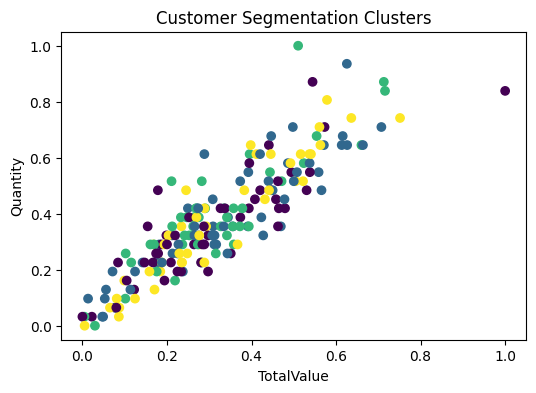

In [47]:
cluster_df["Cluster"] = labels
plt.figure(figsize=(6, 4))
plt.scatter(cluster_df[num_cols[0]], cluster_df[num_cols[1]], c=labels, cmap="viridis")
plt.xlabel(num_cols[0])
plt.ylabel(num_cols[1])
plt.title("Customer Segmentation Clusters")
plt.show()

### PCA plot

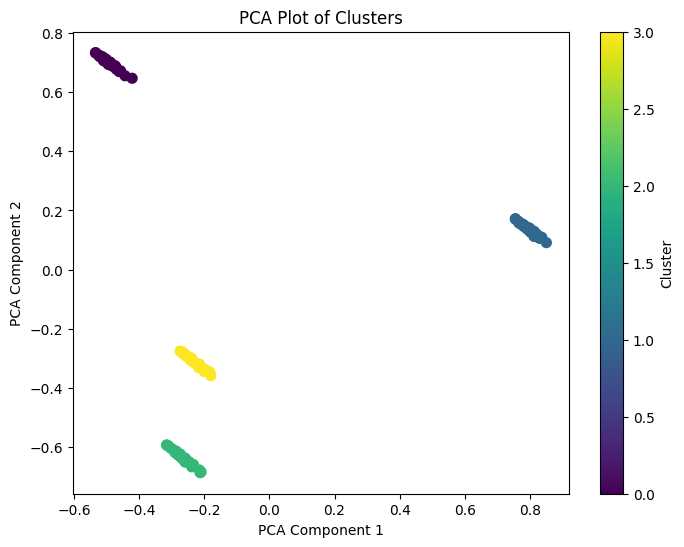

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_df[num_cols])

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap="viridis", s=50)
plt.colorbar(label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Plot of Clusters")
plt.show()

### t-SNE plot

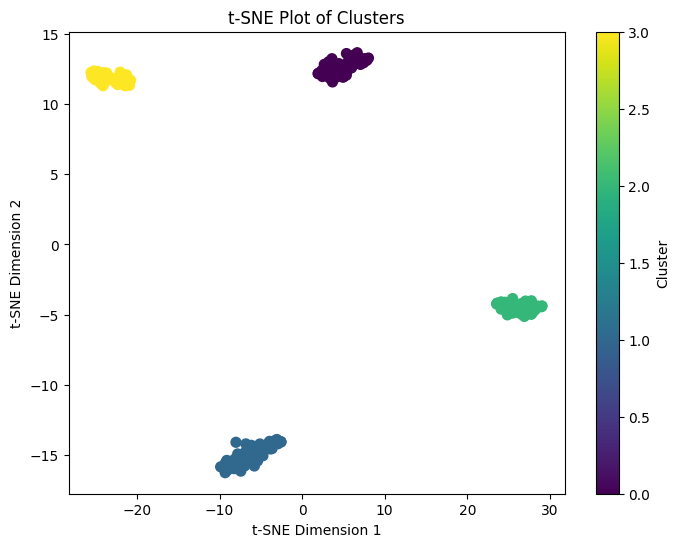

In [35]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="random")
tsne_result = tsne.fit_transform(cluster_df[num_cols])

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap="viridis", s=50)
plt.colorbar(label="Cluster")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Plot of Clusters")
plt.show()